In [1]:
# import modules
import datetime #, timedelta
import time
import json
import pandas as pd
import numpy as np
import decimal
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scienceplots
import matplotlib 

# from plotly.subplots import make_subplots
import plotly.graph_objects as go

import boto3
from boto3.dynamodb.conditions import Key, Attr

# Obtain secret key for AWS
f = open("secret.txt")
text = f.readlines()

# Access dynamodb on AWS
dynamodb = boto3.resource(
    "dynamodb",
    aws_access_key_id=text[0][:-1],
    aws_secret_access_key=text[1][:-1],
    region_name="us-east-2",
)

    
plt.style.use(['science','ieee','high-vis'])
# plt.rcParams['axes.linewidth'] = 1
# plt.rcParams['figure.dpi'] =300

w = 3.3 
h = 2.5

plt.rcParams['figure.constrained_layout.use'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]

In [3]:
# Scan through all Sessions2 data to get session items
table = dynamodb.Table('Sessions2')
params = {'ProjectionExpression': "dcosId,userId,user_email,vehicle_model,vehicle_maxChgRate_W,siteId,stationId,connectTime,startChargeTime,Deadline,energyReq_Wh,estCost,reg_centsPerHr,sch_centsPerHr,sch_centsPerKwh,sch_centsPerOverstayHr,#Dur,DurationHrs,choice,regular,scheduled,cumEnergy_Wh,peakPower_W,power,lastUpdate",
          'ExpressionAttributeNames': {"#Dur":"Duration"}}

# Repeat scan until LastEvaluatedKey is None
start = time.time()
done = False
start_key = None
temp = []
while not done:
    if start_key:
        params['ExclusiveStartKey'] = start_key
    response = table.scan(**params)
    temp.extend(response.get('Items', []))
    print("Length of Scanned Items is {0} items".format(len(temp)))
    start_key = response.get('LastEvaluatedKey', None)
    done = start_key is None

# Print elapsed time
end = time.time()
elapsed_time_min = np.floor((end-start)/60)
elapsed_time_sec = (end-start) % 60
elapsed_time = "Elapsed time: %d minutes, %d seconds" % (elapsed_time_min, elapsed_time_sec)
print(elapsed_time)

# Create dataframe
session_df = pd.DataFrame(temp)
del temp


Length of Scanned Items is 660 items
Length of Scanned Items is 1347 items
Length of Scanned Items is 2018 items
Length of Scanned Items is 2695 items
Length of Scanned Items is 3152 items
Elapsed time: 0 minutes, 6 seconds


## Expected Energy Demand, Duration

In [4]:
session_df['connectTime']  = pd.to_datetime(session_df['connectTime'] )
session_df['startChargeTime']  = pd.to_datetime(session_df['startChargeTime'] )
session_df['Deadline']  = pd.to_datetime(session_df['Deadline'] )
session_df['lastUpdate']  = pd.to_datetime(session_df['lastUpdate'])
session_df = session_df.sort_values(by='connectTime')
session_df = session_df[session_df['siteId'] == 25]
session_df['interArrivalTime_min'] = session_df['connectTime'].diff().dt.seconds / 60
plot_df = session_df[session_df['connectTime'].dt.year >= 2022]
session_df['arrHour']=session_df['connectTime'].dt.hour

session_df['cumEnergy_Wh']=session_df['cumEnergy_Wh'].astype(float)
session_df['cumEnergy_KWh']=session_df['cumEnergy_Wh']/1000
session_df['DurationHrs'] = session_df['DurationHrs'].astype(float)

In [5]:
# 1. peakPower_W = 0 and cumEnergy_W = 0: delete  
session_df = session_df[(session_df["peakPower_W"]!=0) & (session_df["cumEnergy_Wh"]!=0)]

# 2. Fix the user peak_powers 
# some users have historical peak power > 6.6 / 7 
user_df = session_df[['userId','peakPower_W','vehicle_maxChgRate_W']].groupby('userId').max()
user_df['session_counts'] = session_df[['userId','peakPower_W']].groupby('userId').count()

validate_users = user_df[(user_df['session_counts']==1) & (user_df['peakPower_W']<=6000) ].index.to_list()
user_df.reset_index(drop=False,inplace=True)

user_df.rename(columns={"peakPower_W":'historical_peakPower_w'},inplace=True)
session_df = session_df.merge(user_df[['userId','historical_peakPower_w']])

In [6]:

optimizer_time = pd.Timestamp(2023, 2, 7, 8)
session_df['endTime'] = session_df['startChargeTime'] + pd.to_timedelta(session_df['Duration'])
cols = ['connectTime','choice','power','endTime','Duration', 'userId', 'Deadline', 'startChargeTime','DurationHrs','dcosId', 'lastUpdate' ]
session_df[(session_df['startChargeTime']>optimizer_time)].sort_values(by='connectTime')[cols]

,connectTime,choice,power,endTime,Duration,userId,Deadline,startChargeTime,DurationHrs,dcosId,lastUpdate
940,2023-02-07 08:32:19,REGULAR,"[{'power_W': 6736, 'timestamp': 1675812017}]",2023-02-07 15:20:17,0 days 06:47:48,792,NaT,2023-02-07 08:32:29,6.79666,4150,2023-02-07 15:20:17
2309,2023-02-07 08:39:32,REGULAR,"[{'power_W': 6682, 'timestamp': 1675806309}]",2023-02-07 13:45:09,0 days 05:03:48,1233,NaT,2023-02-07 08:41:21,5.06333,4151,2023-02-07 13:45:09
1777,2023-02-07 09:02:28,SCHEDULED,"[{'power_W': 4497, 'timestamp': 1675810509}]",2023-02-07 14:55:09,0 days 05:51:44,1126,2023-02-07 15:00:00,2023-02-07 09:03:25,5.86222,4153,2023-02-07 14:55:09
1386,2023-02-07 09:19:18,REGULAR,"[{'power_W': 3576, 'timestamp': 1675806309}]",2023-02-07 13:45:09,0 days 04:24:03,988,NaT,2023-02-07 09:21:06,4.40083,4154,2023-02-07 13:45:09
1980,2023-02-07 09:50:38,REGULAR,"[{'power_W': 6624, 'timestamp': 1675809308}]",2023-02-07 14:35:08,0 days 04:44:16,1149,NaT,2023-02-07 09:50:52,4.73777,4155,2023-02-07 14:35:08
...,...,...,...,...,...,...,...,...,...,...,...
2254,2023-02-23 09:37:30,REGULAR,"[{'power_W': 6615, 'timestamp': 1677175209}, {...",2023-02-23 15:50:08,0 days 06:10:25,1178,NaT,2023-02-23 09:39:43,6.17361,4315,2023-02-23 15:50:08
2380,2023-02-23 14:48:02,REGULAR,"[{'power_W': 6680, 'timestamp': 1677192609}, {...",2023-02-23 21:20:08,0 days 06:31:46,1271,NaT,2023-02-23 14:48:22,6.52944,4317,2023-02-23 21:20:08
2166,2023-02-23 15:22:08,REGULAR,"[{'power_W': 4926, 'timestamp': 1677194708}, {...",2023-02-23 20:50:08,0 days 05:27:39,1180,NaT,2023-02-23 15:22:29,5.46083,4318,2023-02-23 20:50:08
2384,2023-02-23 19:38:10,SCHEDULED,"[{'power_W': 6843, 'timestamp': 1677210308}, {...",2023-02-23 21:55:07,0 days 02:13:39,1276,2023-02-24 01:30:00,2023-02-23 19:41:28,2.22750,4320,2023-02-23 21:55:07


In [7]:
high_power_idx = list(session_df[session_df['historical_peakPower_w'] >= 5000].index)
low_power_idx = list(session_df[session_df['historical_peakPower_w'] < 5000].index)

session_df['highPower'] = pd.Series(dtype=int)

session_df.loc[high_power_idx ,'highPower'] = 1
session_df.loc[low_power_idx ,'highPower'] = 0

session_df.loc[high_power_idx ,'userPower_kW'] = 6.6
session_df.loc[low_power_idx ,'userPower_kW'] = 3.3

In [8]:
plt.rcParams['figure.dpi'] =300

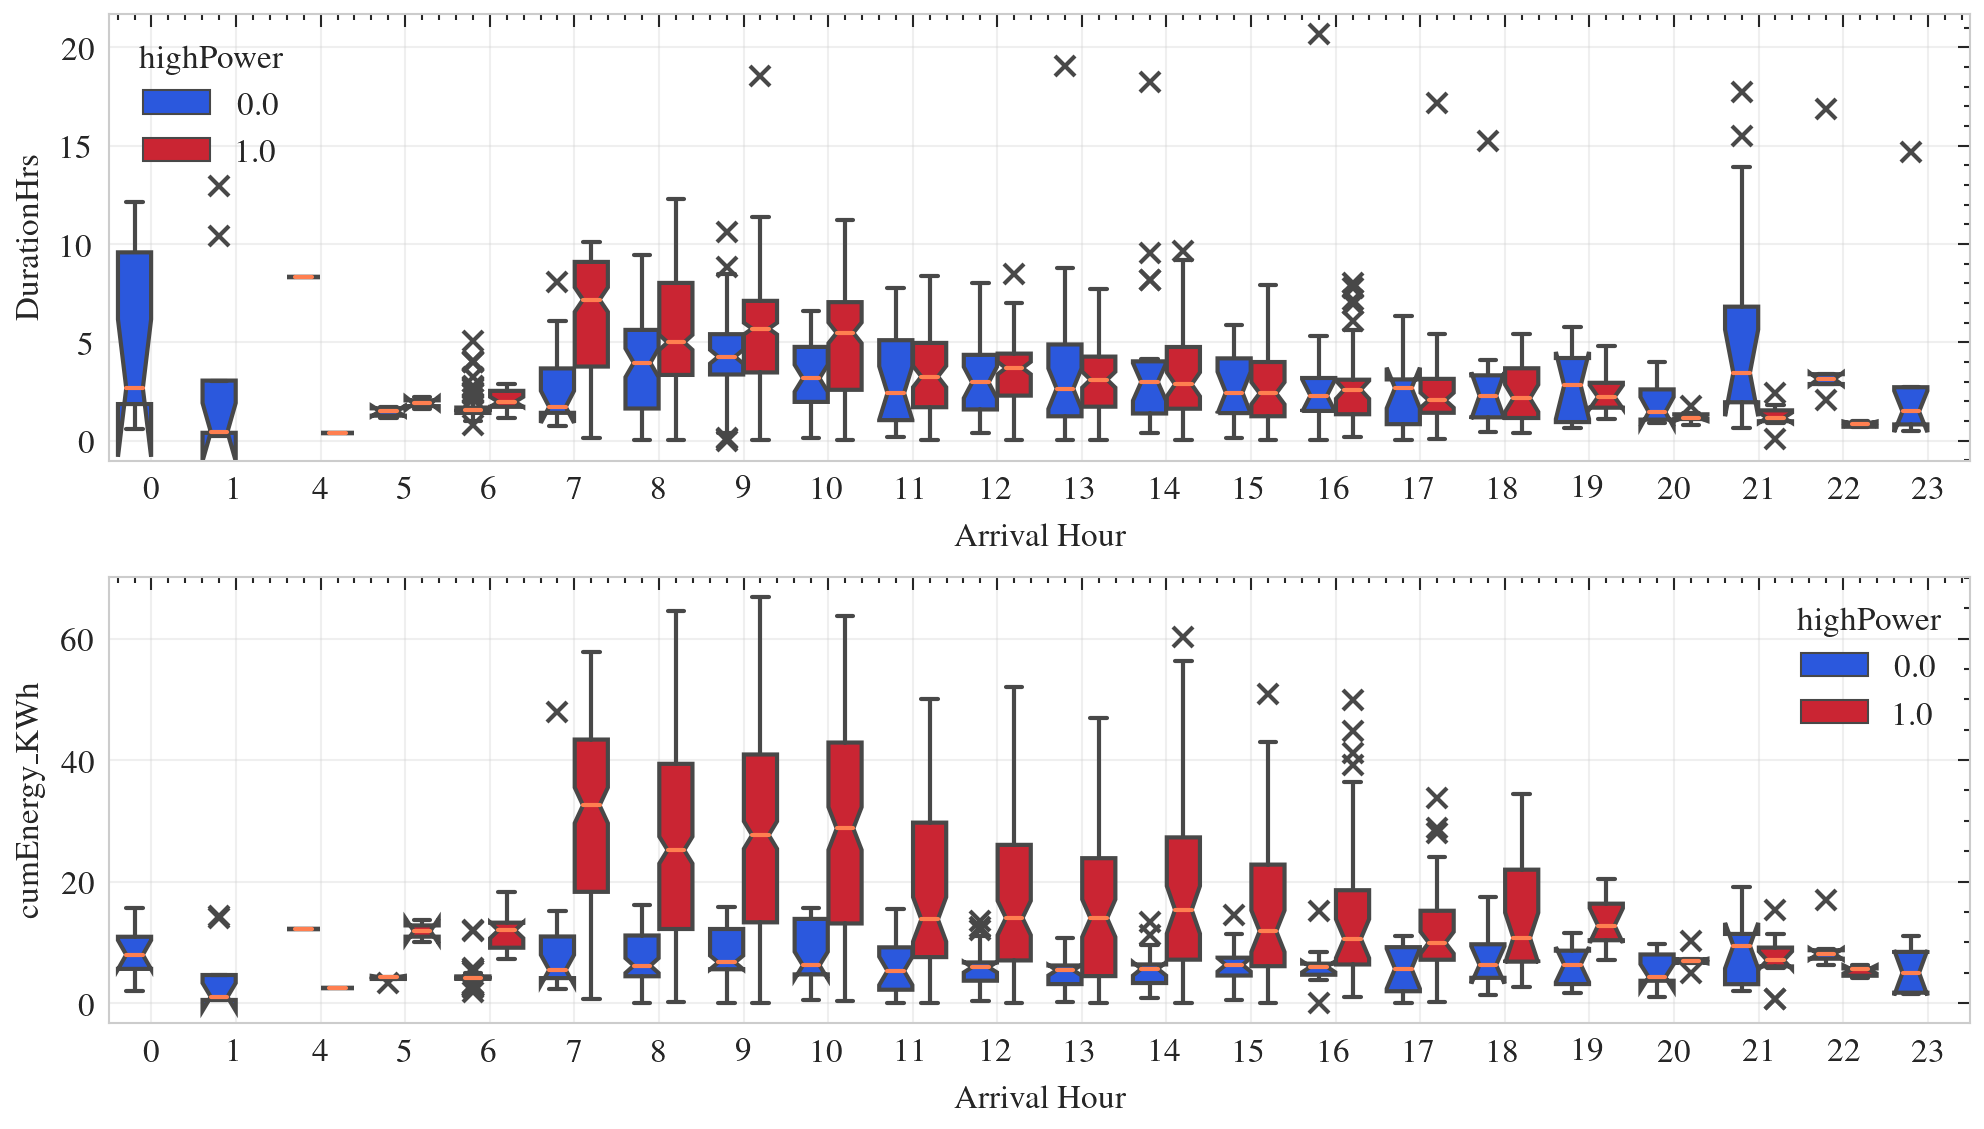

In [9]:
fig,ax= plt.subplots(2,1,figsize=( w*2, h*1.5 ))



sns.boxplot(
    data=session_df, x="arrHour", y="DurationHrs",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[0]
)

sns.boxplot(
    data=session_df, x="arrHour", y="cumEnergy_KWh",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[1]
)

for i in [0,1]:
    ax[i].grid(alpha=0.3)
    ax[i].set_xlabel("Arrival Hour")



In [25]:
iterables = [[0,1], range(0,24)]
idx = pd.MultiIndex.from_product(iterables, names=['highPower','arrHour'])
# pd.DataFrame(index=idx,columns = ['DurationHrs', 'cumEnergy_Wh', 'interArrivalTime_min', 'arrivalHour','cumEnergy_KWh', 'count'])
expected_demand = session_df.groupby(['highPower','arrHour']).mean()
expected_demand['count'] = session_df.groupby(['highPower','arrHour']).count()['dcosId']
expected_demand = expected_demand.reindex(idx).reset_index(drop=False)
expected_demand.rename(columns = {'cumEnergy_Wh':"estEnergyWh", 
                                  'cumEnergy_KWh':"estEnergykWh", 
                                  "DurationHrs":"estDurationHrs"},inplace=True)


expected_demand['count'].fillna(0,inplace=True)
# expected_demand.fillna(method='ffill',inplace=True)

In [26]:
for i in range(0, len(expected_demand), 24):
    group = expected_demand.iloc[i:i+24]
    # if group.iloc[0].isna().any():
    #     group.iloc[0].fillna(method='bfill', inplace=True)
    group.fillna(method='ffill', inplace=True)
    group.fillna(method='bfill', inplace=True)

In [27]:
expected_demand

,highPower,arrHour,estDurationHrs,estEnergyWh,interArrivalTime_min,estEnergykWh,userPower_kW,count
0,0,0,5.115760,8349.500000,533.111111,8.349500,3.3,12.0
1,0,1,3.232010,4157.500000,379.047917,4.157500,3.3,8.0
2,0,2,3.232010,4157.500000,379.047917,4.157500,3.3,0.0
3,0,3,3.232010,4157.500000,379.047917,4.157500,3.3,0.0
4,0,4,8.323880,12213.000000,704.250000,12.213000,3.3,1.0
5,0,5,1.465440,3995.000000,1003.226667,3.995000,3.3,5.0
6,0,6,1.637458,4215.265306,993.837483,4.215265,3.3,245.0
7,0,7,2.778343,9230.684211,807.736842,9.230684,3.3,19.0
8,0,8,4.005247,7516.594595,361.381081,7.516595,3.3,74.0
9,0,9,4.323759,8331.211765,230.210784,8.331212,3.3,85.0


# Test Station Level Optimizer
Currently optimizer works only with the simulator. <br>
Start with the simple case: Run with no-on going sessions. 



In [28]:
import optimizer_station as opt
# We define the timesteps in the APP as 15 minute 
delta_t = 0.25 #hour 
print("For delta_t: ",delta_t, "max number of intervals:",24/delta_t)
################## Define the TOU Cost ##########################################
## the TOU cost is defined considering the delta_t above, if not code raises an error.##

# off-peak 0.175  cents / kwh 
TOU_tariff = np.ones((96,)) * 17.5
## 4 pm - 9 pm peak 0.367 cents / kwh 
TOU_tariff[64:84] = 36.7
## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh

TOU_tariff[36:56] = 14.9

For delta_t:  0.25 max number of intervals: 96.0


In [29]:
 opt.Parameters?

In [30]:
%%time
## Task 1: Run for 24 hours with no on going sessions 

expected_demand['sch_centsPerHr'] = pd.Series()
expected_demand['reg_centsPerHr'] = pd.Series()
expected_demand['sch_expected_power_W'] = pd.Series()
expected_demand['reg_expected_power_W'] = pd.Series()

#### TODO: YIFEI RUN OPTIMIZER FOR THE EACH ROW IN THIS DATAFRAME WITH 0 DEMAND CHARGE PENALTY ####
# ASSUME NO VEHICLES
# DON'T USE SINGLE CHARGER, ONLY USE STATION LEVEL OPTIMIZER
# When recording the powers use the same format in the sessions.csv

par = opt.Parameters(z0 = np.array([25, 30, 1, 1]).reshape(4, 1),
                         Ts = delta_t,
                         eff = 1.0,
                         soft_v_eta = 1e-4,
                         opt_eps = 0.0001,
                         TOU = TOU_tariff)

for row in range(len(expected_demand)):

    if expected_demand.loc[row, 'estDurationHrs'] > 0:
        try:
            arrival_hour = expected_demand.loc[row, 'arrHour']
            duration_hour = expected_demand.loc[row, 'estDurationHrs']
            e_need = expected_demand.loc[row, 'estEnergykWh']

            ### Yifei: Also do we define the event here or in the optimizer?
            event = {
                "time": int(arrival_hour / delta_t),
                "e_need": e_need,
                "duration": int(duration_hour / delta_t),
                "station_pow_max": 6.6,
                "user_power_rate": expected_demand.loc[row, 'userPower_kW'],
                "limit_reg_with_sch": False,
                "limit_sch_with_constant": False,
                "sch_limit": 0
            }

            prb = opt.Problem(par=par, event=event)

            # Yifei: The station object, here we assume no ongoing sessions. The form of this object is not decided yet. Dict or Class?
            station = {}
            station['FLEX_list'] = list()
            station['ASAP_list'] = list()

            obj = opt.Optimization_station(par, prb, station, arrival_hour)
            station, res = obj.run_opt()

            reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']

            expected_demand.loc[row, 'sch_centsPerHr'] = sch_centsPerHr 
            expected_demand.loc[row, 'reg_centsPerHr'] = reg_centsPerHr 
            expected_demand.loc[row, 'sch_expected_power_W' ] = json.dumps(list(res["sch_powers"].flatten()))
            expected_demand.loc[row, 'reg_expected_power_W' ] = json.dumps(list(res["reg_powers"].flatten()))
        except AssertionError:
            print("Error:",row)
    else:
        expected_demand.loc[row, 'sch_centsPerHr'] = 0
        expected_demand.loc[row, 'reg_centsPerHr'] = 0

After 14 iterations, we got -0.248526  improvements, and claim convergence.
The prices are 28.270522 30.630958
After 14 iterations, we got -0.125375  improvements, and claim convergence.
The prices are 28.412441 30.787855
After 14 iterations, we got -0.125375  improvements, and claim convergence.
The prices are 28.412441 30.787855
After 14 iterations, we got -0.125375  improvements, and claim convergence.
The prices are 28.412441 30.787855
After 4 iterations, we got -0.382732  improvements, and claim convergence.
The prices are 25.390476 29.860245
After 14 iterations, we got -0.119591  improvements, and claim convergence.
The prices are 28.341511 30.709434
After 14 iterations, we got -0.125457  improvements, and claim convergence.
The prices are 28.347215 30.707078
After 9 iterations, we got -0.078449  improvements, and claim convergence.
The prices are 27.344094 30.597893
After 4 iterations, we got -0.042776  improvements, and claim convergence.
The prices are 25.897011 30.221593
Afte

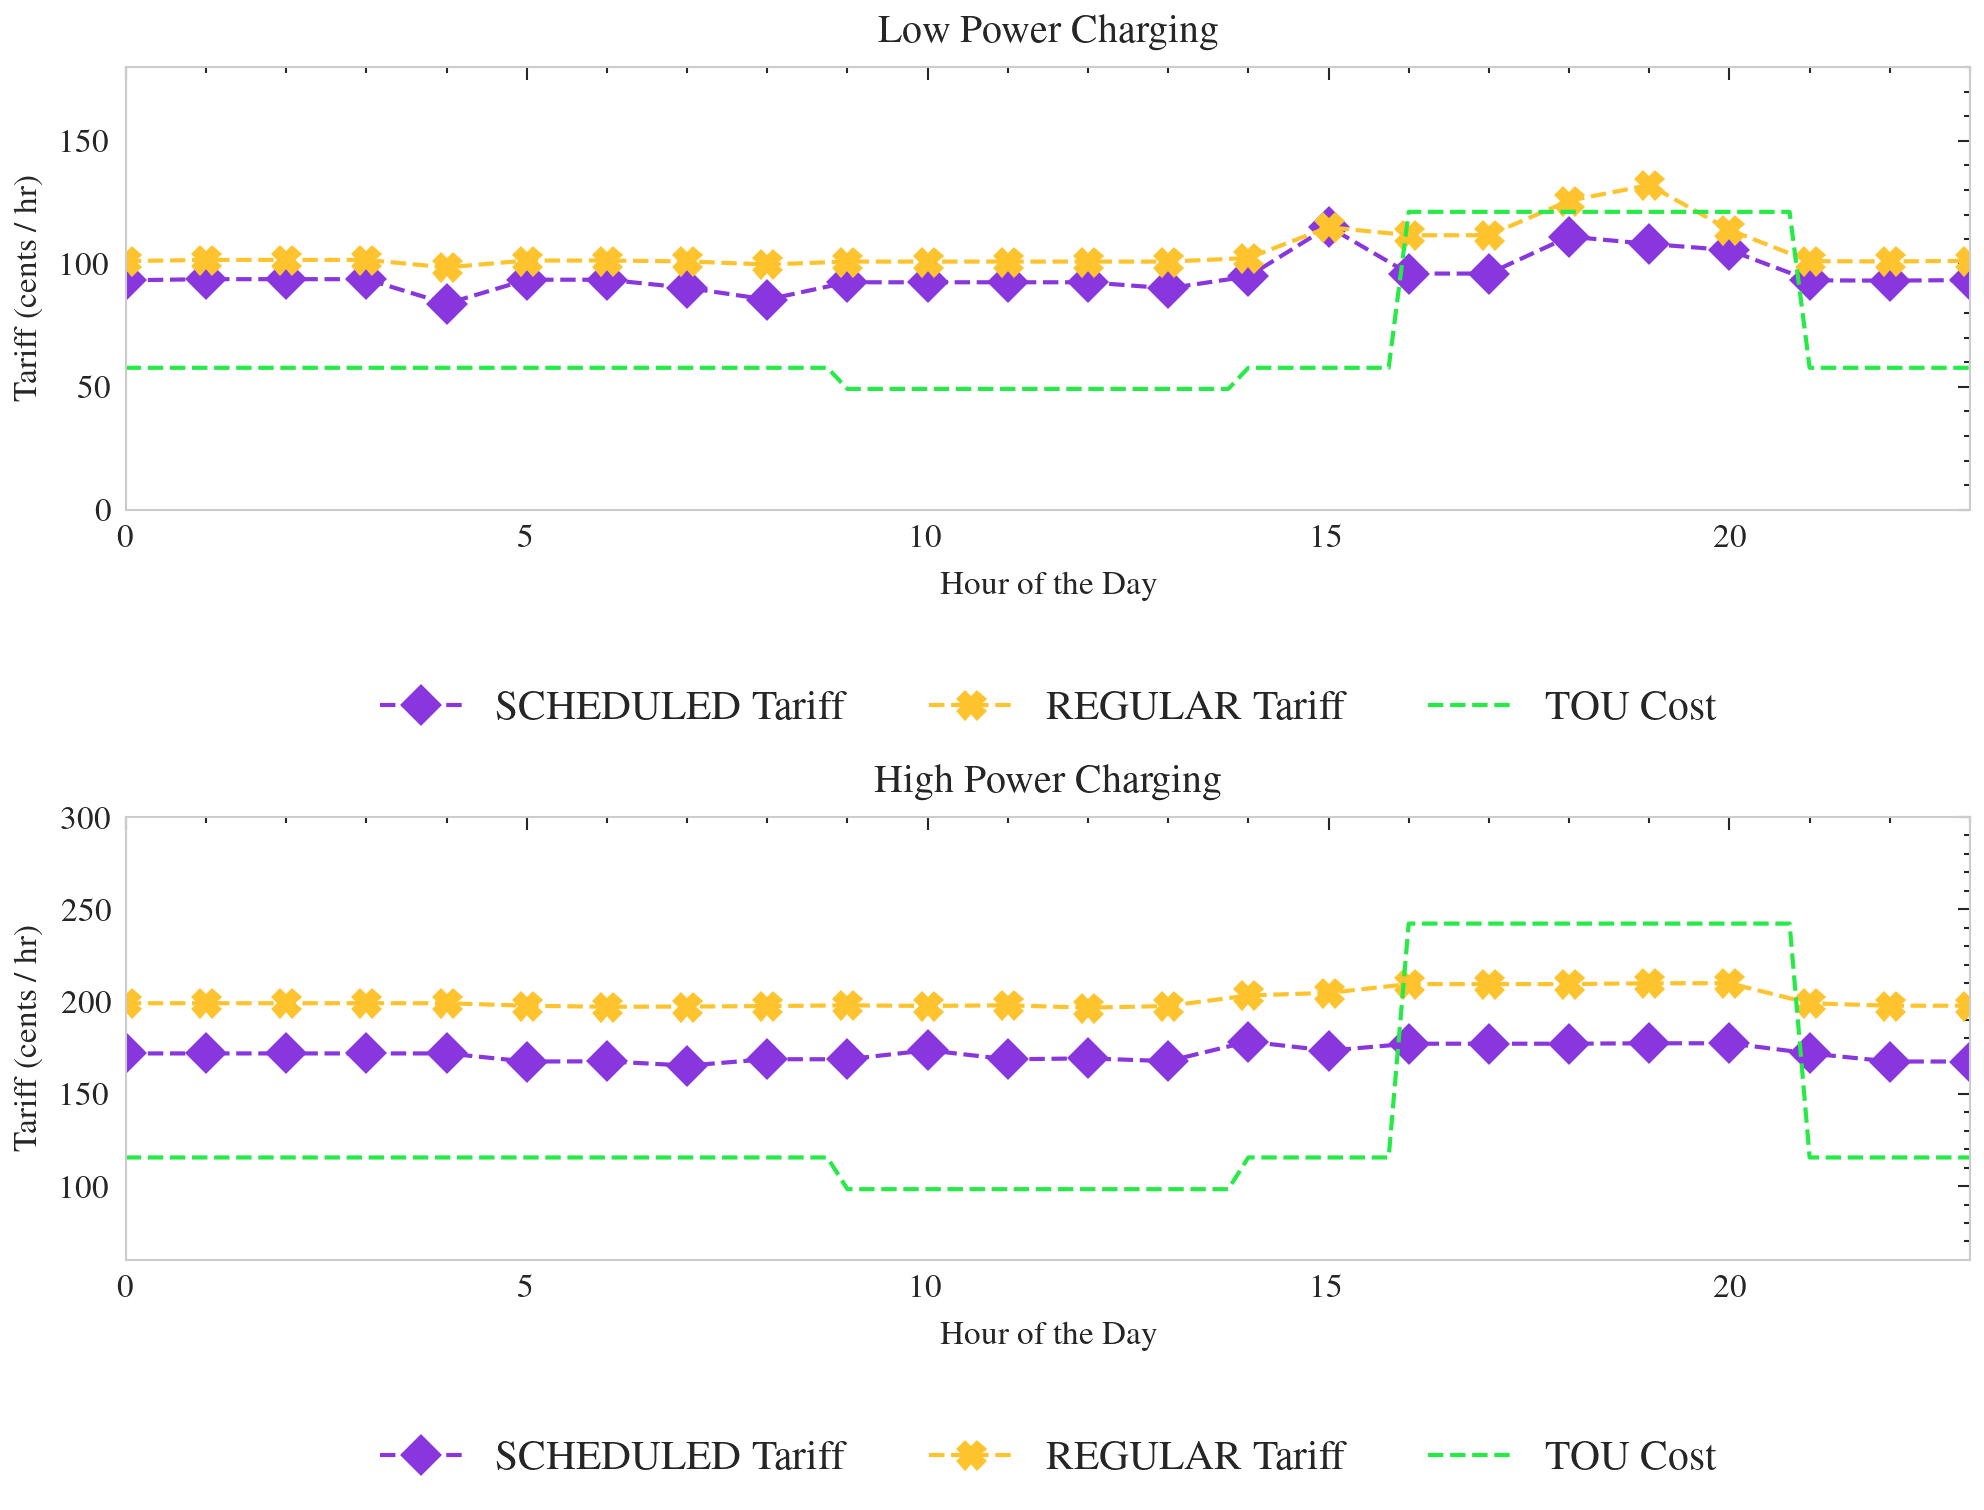

In [34]:
high_TOU = TOU_tariff * 6.6
low_TOU = TOU_tariff * 3.3

# Plot initial guess vs optimization result 
fig,axes= plt.subplots(2,1,figsize=(w * 2 ,h*2))
# Objective Value for each iteration 
ax=axes[0]
arrHour = expected_demand[expected_demand['highPower']==0]['arrHour'].values

expected_demand['reg_centsPerHr'].values
expected_demand['sch_centsPerHr'].values

ax.plot(arrHour, expected_demand[expected_demand['highPower']==0]['sch_centsPerHr'].values, 
        label = 'SCHEDULED Tariff', 
        marker = 'D',
        linestyle = "--",color=high_vis_map[3])
ax.plot(arrHour, expected_demand[expected_demand['highPower']==0]['reg_centsPerHr'].values, color=high_vis_map[4], label = 'REGULAR Tariff',marker ='X',linestyle = "--")
ax.plot(np.arange(0,24,0.25), low_TOU, label = 'TOU Cost', ms=0,marker ='X',
        linestyle = "--",
       color=high_vis_map[2])

ax.set_ylim(0,180)
ax.set_xlim(0,23)
ax.grid()
ax.set_title("Low Power Charging")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Tariff (cents / hr)")
# ax.set_title("Objective Value")
ax.legend(loc = 0)
ax.legend(bbox_to_anchor=(0.5, -0.45), loc='center', ncol=3,fontsize=10)


ax=axes[1]
arrHour = expected_demand[expected_demand['highPower']==1]['arrHour'].values

expected_demand['reg_centsPerHr'].values
expected_demand['sch_centsPerHr'].values

ax.plot(arrHour, expected_demand[expected_demand['highPower']==1]['sch_centsPerHr'].values, 
        label = 'SCHEDULED Tariff', 
        marker = 'D',
        linestyle = "--",color=high_vis_map[3])
ax.plot(arrHour, expected_demand[expected_demand['highPower']==1]['reg_centsPerHr'].values, color=high_vis_map[4], label = 'REGULAR Tariff',marker ='X',linestyle = "--")
ax.plot(np.arange(0,24,0.25), high_TOU, label = 'TOU Cost', ms=0,marker ='X',
        linestyle = "--",
       color=high_vis_map[2])

ax.set_ylim(60,300)
ax.set_xlim(0,23)
ax.grid()
ax.set_title("High Power Charging")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Tariff (cents / hr)")
# ax.set_title("Objective Value")
ax.legend(loc = 0)
ax.legend(bbox_to_anchor=(0.5, -0.45), loc='center', ncol=3,fontsize=10)

# fig.savefig('Figures/fig2a.pdf', dpi=300)

# Plot Powers

In [35]:
import json
import math
from analysis import plot_max_min_power, plot_arrival_departure

In [36]:
expected_demand[(expected_demand['highPower']==1)].set_index('arrHour')

,highPower,estDurationHrs,estEnergyWh,interArrivalTime_min,estEnergykWh,userPower_kW,count,sch_centsPerHr,reg_centsPerHr,sch_expected_power_W,reg_expected_power_W
arrHour,,,,,,,,,,,
0,1,0.387770,2471.000000,501.550000,2.471000,6.6,0.0,171.869841,199.080527,"[6.6, 3.284000000000001]","[6.6, 3.284000000000001]"
1,1,0.387770,2471.000000,501.550000,2.471000,6.6,0.0,171.869841,199.080527,"[6.6, 3.284000000000001]","[6.6, 3.284000000000001]"
2,1,0.387770,2471.000000,501.550000,2.471000,6.6,0.0,171.869841,199.080527,"[6.6, 3.284000000000001]","[6.6, 3.284000000000001]"
3,1,0.387770,2471.000000,501.550000,2.471000,6.6,0.0,171.869841,199.080527,"[6.6, 3.284000000000001]","[6.6, 3.284000000000001]"
4,1,0.387770,2471.000000,501.550000,2.471000,6.6,1.0,171.869841,199.080527,"[6.6, 3.284000000000001]","[6.6, 3.284000000000001]"
5,1,1.907635,11853.500000,1084.550000,11.853500,6.6,2.0,167.485257,197.714210,"[6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 1.21400000...","[6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 1.21400000..."
6,1,2.046651,11861.520000,589.464000,11.861520,6.6,25.0,167.599386,197.143731,"[6.2559960771275085, 6.2559960771275085, 6.151...","[6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 1.24608000..."
7,1,6.437742,31021.005556,413.368611,31.021006,6.6,180.0,165.263659,197.272112,"[2.4476093182111303, 2.447609318211134, 2.4476...","[6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, ..."
8,1,5.421100,26853.651351,207.343018,26.853651,6.6,370.0,168.744363,197.528481,"[2.0986302611828675e-11, 2.098630261188004e-11...","[6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, ..."


Text(0.5, 0.98, 'Hour 10')

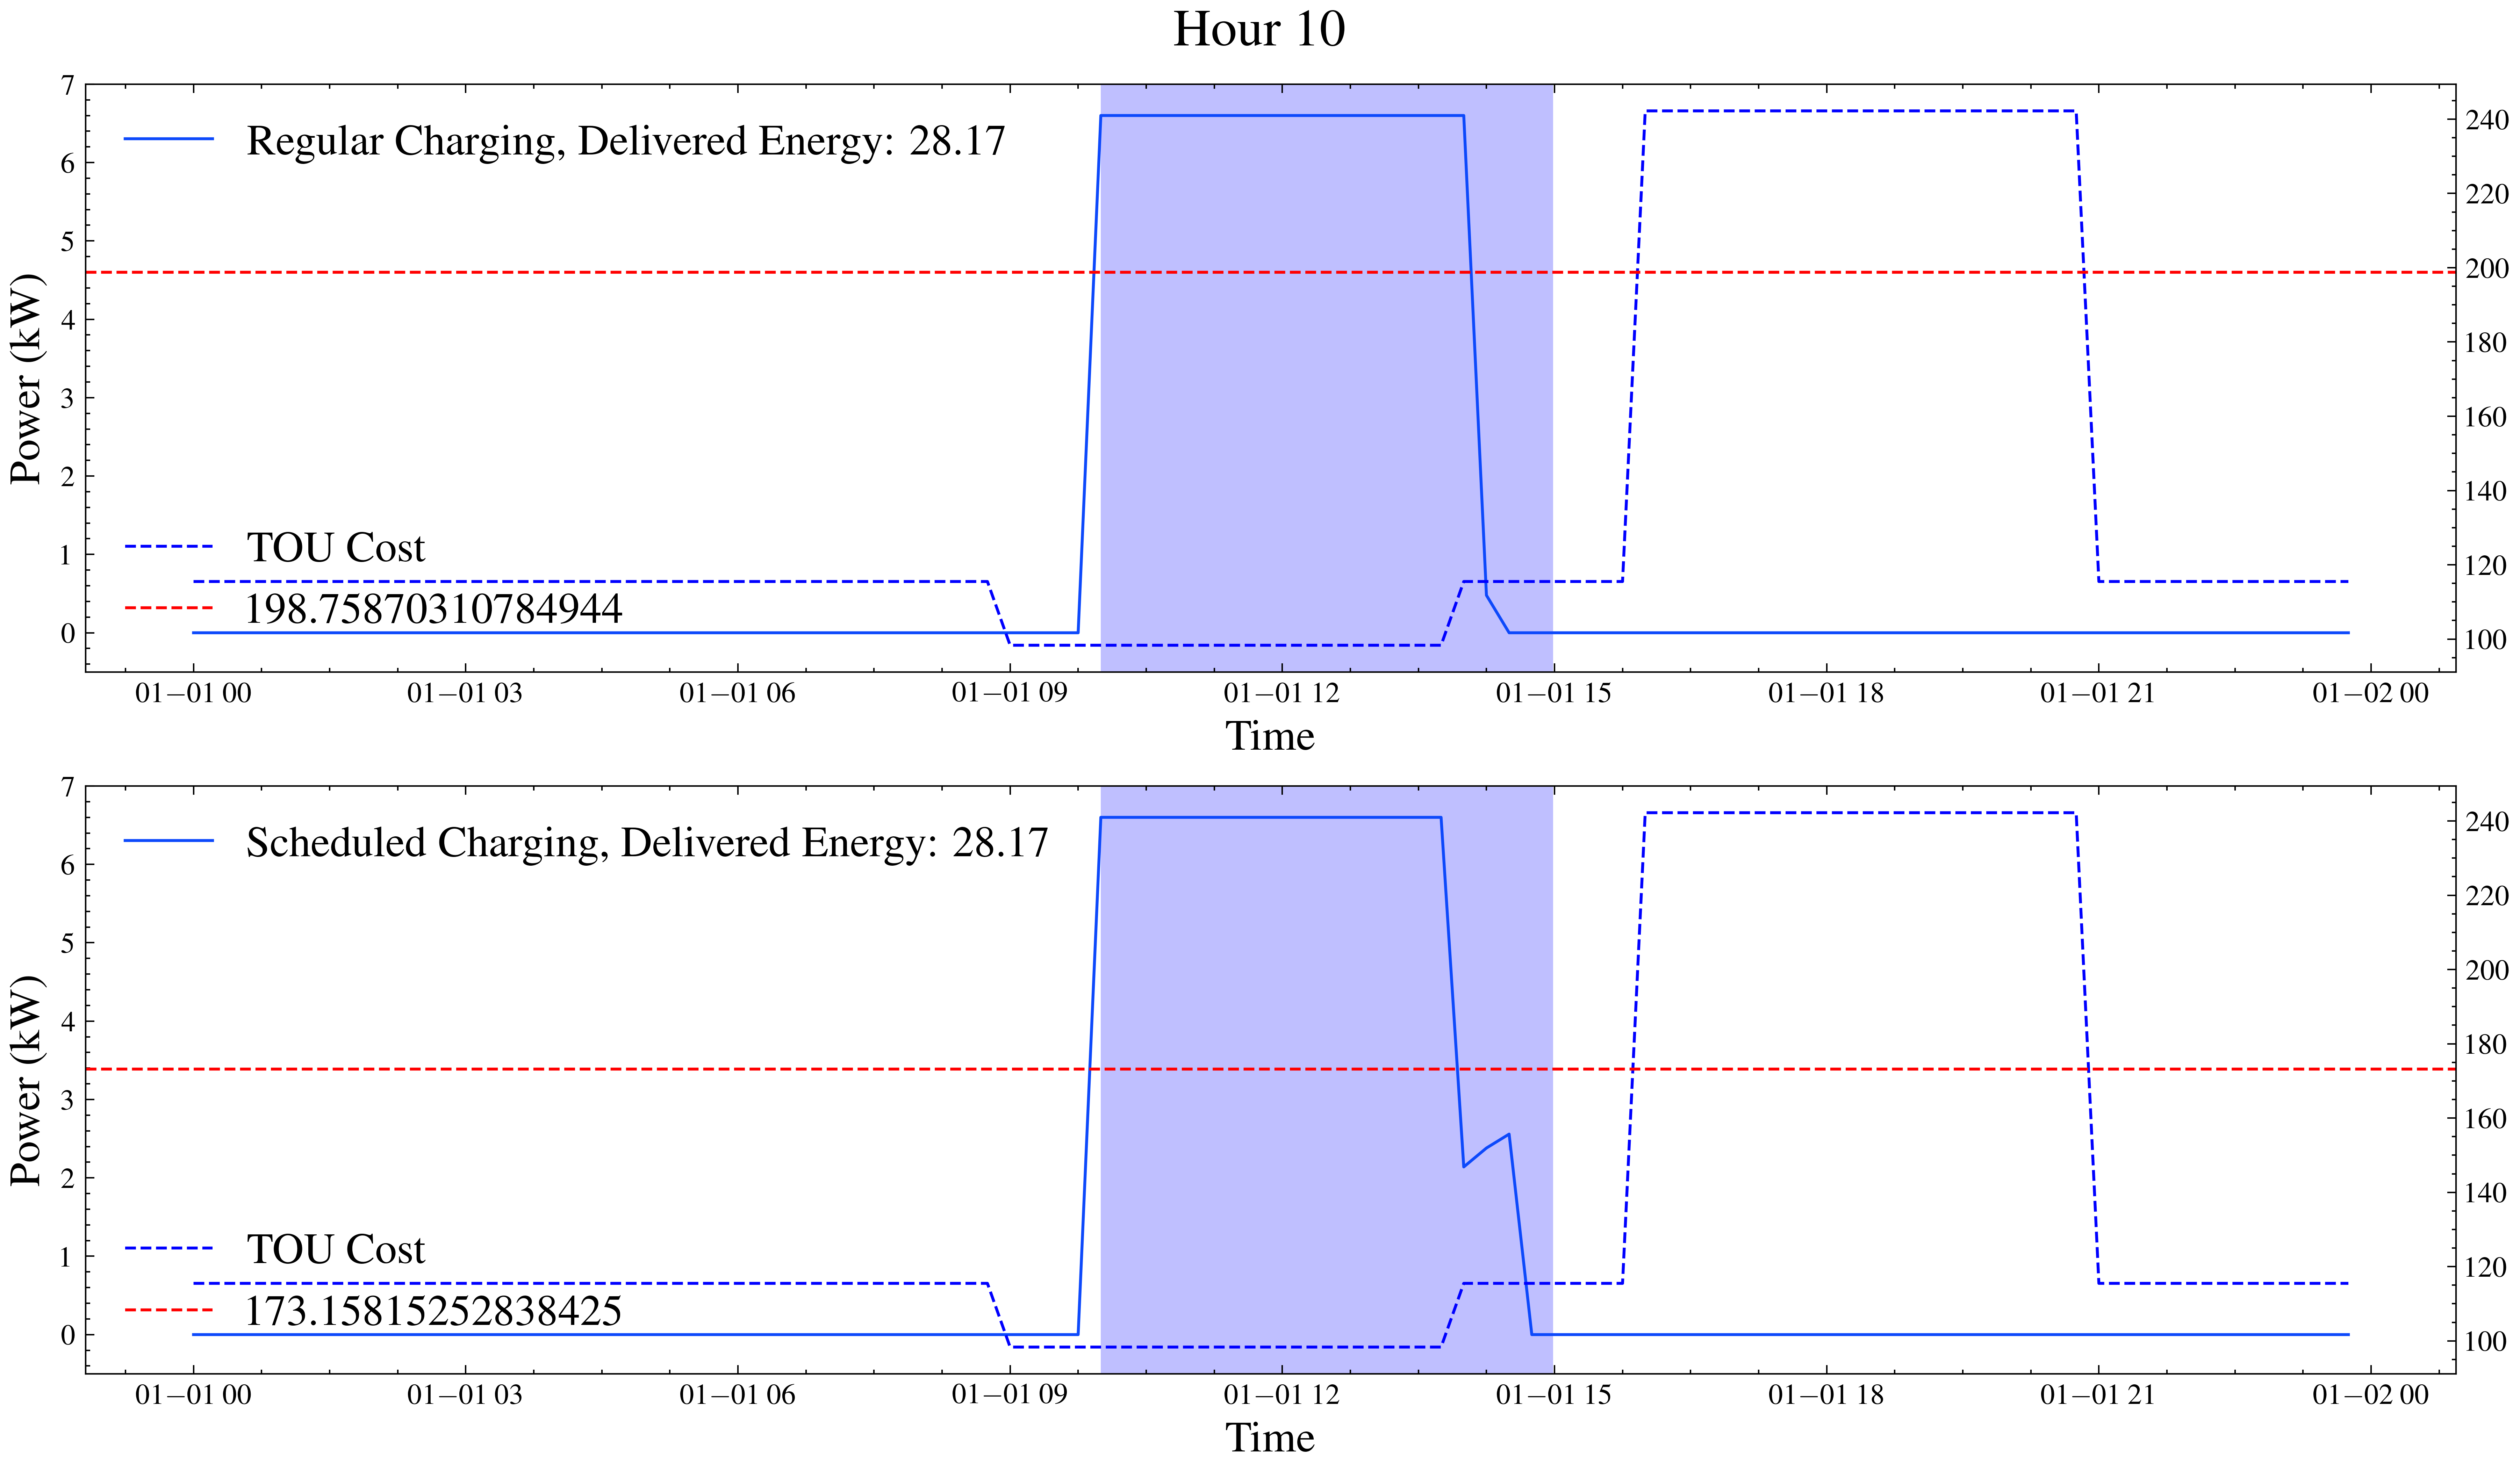

In [49]:
#### RECORD AND CHECK ALL HOURS MAYBE PUT THEM IN A GOOGLE SLIDES. COMMENT ON THE RESULTS. LABEL THE PROBLEM CASES IF ANY. 
steps_in_hr = 4
eff = 1 
interval_size_minutes = int(60 * delta_t)
assert steps_in_hr == int(1/delta_t)

arrHour = 10
station_pow_max = 6.6
interval_size_hour = 0.25

high_powers = expected_demand[(expected_demand['highPower']==1)].set_index('arrHour')

power = np.array(json.loads(high_powers.loc[arrHour,'sch_expected_power_W']))
e_need = high_powers.loc[arrHour ,"estEnergykWh"]
duration = high_powers.loc[arrHour ,"estDurationHrs"]

arrival_interval = int(arrHour *steps_in_hr)
duration_interval =  int(duration * 60 / interval_size_minutes)


###### HAVE THE SAME DISCRETIZATION HERE IN THE OPTIMIZER ############################
N_asap = math.ceil((e_need / station_pow_max / eff * int(1 / interval_size_hour)))
N_asap_remainder = (e_need / station_pow_max / eff * int(1 / interval_size_hour)) % 1


try:
    sch_arr = np.zeros((96,1))
    reg_arr = np.zeros((96,1))  
    timerange = pd.date_range("1/1/2021", periods=96, freq="{}min".format(interval_size_minutes ))
    sch_arr[arrival_interval:(arrival_interval+duration_interval)] = power.reshape((duration_interval,1))
    reg_arr[arrival_interval:(arrival_interval+N_asap)] = station_pow_max 
    reg_arr[(arrival_interval+N_asap) - 1] = station_pow_max * N_asap_remainder

except: 
    timerange = pd.date_range("1/1/2021", periods=96 * 2, freq="{}min".format(interval_size_minutes))
    sch_arr = np.zeros((96*2,1))
    reg_arr = np.zeros((96*2,1))
    sch_arr[arrival_interval:(arrival_interval+duration_interval)] = power.reshape((duration_interval,1))
    reg_arr[arrival_interval:(arrival_interval+N_asap)] = station_pow_max
    reg_arr[(arrival_interval+N_asap) - 1] = station_pow_max * N_asap_remainder
    high_TOU = np.concatenate([high_TOU,high_TOU])


fig,(ax1, ax2) = plt.subplots(2,1,figsize=(12,7) ,)

ax1.plot(timerange, reg_arr, label = "Regular Charging, Delivered Energy: "+str(np.round(np.sum(reg_arr * 0.25),2)))
ax = ax1.twinx()
ax.plot(timerange , high_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")

reg_price_cents_hour = high_powers.loc[arrHour,'reg_centsPerHr']
ax.axhline(reg_price_cents_hour  ,linestyle='--',color='red', 
           label = reg_price_cents_hour)
ax.legend(loc=3)
ax2.plot(timerange, sch_arr, label = "Scheduled Charging, Delivered Energy: "+str(np.round(np.sum(sch_arr * 0.25),2)))
ax = ax2.twinx()

sch_price_cents_hour = high_powers.loc[arrHour,'sch_centsPerHr']


ax.plot(timerange , high_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")
ax.axhline(sch_price_cents_hour  ,linestyle='--',color='red', 
           label =sch_price_cents_hour)
ax.legend(loc=3)
plot_arrival_departure([ax1,ax2], arrHour, 0, int(arrHour + duration), 
                       int(60 * ((arrHour + duration) % int(arrHour + duration))))

# plot_max_min_power([ax1,ax2],6.6)
for ax in [ax1,ax2]:
    ax.set_ylim(-0.5,7)
    ax.legend(loc=0)
    ax.legend(loc=0)
    ax.set_xlabel("Time")
    ax.set_ylabel("Power (kW)")


fig.suptitle("Hour {}".format(arrHour))

In [40]:
optimizer_time = pd.Timestamp(2023, 2, 7, 8, 0, 0)
print(optimizer_time)
print(pd.to_datetime(optimizer_time).value)

2023-02-07 08:00:00
1675756800000000000


In [42]:
def unixTime(timeStamp):
    return pd.to_datetime(timeStamp).value

## Check this for the format of the final output powers. You can generate it as you wish. 

def dummyUserPower(choice):
    
    """ Returns Array but this can also be a dictionary """
    
    t0 = unixTime(pd.Timestamp(2023, 2, 7, 7, 30 , 0 ))
    t1 = unixTime(pd.Timestamp(2023, 2, 7, 7, 45 , 0 ))
    t2 = unixTime(pd.Timestamp(2023, 2, 7, 8, 0 , 0 )) ## Current TS
    t3 = unixTime(pd.Timestamp(2023, 2, 7, 8, 15 , 0 ))
    t4 = unixTime(pd.Timestamp(2023, 2, 7, 8, 30 , 0 ))
    t5 = unixTime(pd.Timestamp(2023, 2, 7, 8, 45 , 0 ))
    
    p0 = 3000
    p1 = 3000
    p2 = 3000
    p3 = 3000
    p4 = 3000
    p5 = 0
    
    if choice == "REG":

    
        powers = np.array([ [t0, p0], [t1, p1], [t2, p2], [t3, p3], [t4, p4],[t5, p5]])

    elif choice == "SCH":
        powers = np.array([ [t0, 0], [t1, p1], [t2, p2], [t3, p3], [t4, p4],[t5, 3000]])
    else:
        power = np.zeros(shape=(6,2))
    return powers

def dummyStateRecord():
    """ 
    Returns: List of Dictionaries
    Each entry is a state dictionary with keys: 
    
    monthlyPeak, int
    timeStamp, int
    sessions, list of dictionaries with keys
    dcosId, int
    choice, string
    powerRate, string
    energyNeeded, float
    deadline, int
    optPower, array 
        """
    
    stateRecord = [
        {"monthlyPeak":18, 
         "timeStamp":unixTime(pd.Timestamp(2023, 2, 7, 7, 45 , 0 )), ## Last record TS(decision of the last vehicle)
         "sessions": [ 
             {
                "dcosId" : 1001,
                "choice": "SCH",
                "powerRate": "HIGH",
                "energyNeeded" : 3750,
                "deadline" : unixTime(pd.Timestamp(2023, 2, 7, 8, 45 , 0 )), # So here the values are all discretized to 15 min intervals?
                "optPower" : dummyUserPower("SCH") 
             }, 
             {
                "dcosId" : 1002,
                "choice": "REG",
                "powerRate": "HIGH",
                "energyNeeded" : 3750,
                "deadline" : unixTime(pd.Timestamp(2023, 2, 7, 8, 45 , 0 )),
                "optPower" : dummyUserPower("REG") 
             }, 
         ]
        }
    ]
    print(stateRecord[0]["sessions"][0]["optPower"][:,1].sum() * 0.25)
#     assert  == 3750
    
    return stateRecord

def arrHourList(arrHour, optHorizon):
    """ arrHour, int: current optimization hour
        optHorizon, int: how long to optimize in hours """ 
    if arrHour <= (24-optHorizon): 
        return list(range(arrHour,(arrHour+optHorizon)))
    else: 
        lst = list(range(arrHour,24))
        lst.extend(list(range( 0 , ((arrHour+optHorizon)-24) )))

        return lst 


In [41]:
import datetime
def data_format_convertion(stateRecords, opt_hour, delta_t):
    stateRecord = stateRecords[0]["sessions"].copy()
    if not stateRecord:
        return None
    # num_users = len(stateRecord)
    res = []
    for user in stateRecord:
        user["optPower"] = user["optPower"].tolist()
        user["powerRate"] = 6.6 if user["powerRate"] == "HIGH" else 3.3

        start_time_obj = datetime.datetime.fromtimestamp(user["optPower"][0][0]) # the timestamp of the first time slot
        user["start_time"] = float(start_time_obj.hour + start_time_obj.minute / 60)

        end_time_obj = datetime.datetime.fromtimestamp(user["optPower"][-1][0]) # Or retrieve the last time slot??
        user["end_time"] = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
        if user["end_time"] <= opt_hour:
            continue

        user["optPower"] = np.array([x[1] for x in user["optPower"]])
        user["price"] = 25 if user["choice"] == "SCH" else 30
        user["energyNeeded"] = float(user["energyNeeded"])
        del(user["deadline"])
        res.append(user)

    return res

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


For stateRecords with multiple timestamps, do we sort it every time to make sure stateRecord[0] is the last timestamp?

Where should I check the status(are vehicles still in the station)? Inside or outside optimizer?

Also need the TOU(can be derived from start and deadline and global TOU) and prices for existing vehicles!

In [179]:
## TO-DO Yifei Function Here 
def generateOptPricePower(expectedDemand):
    
    optTime = pd.Timestamp(2023, 2, 7, 8, 0 , 0 )
    unixOptTime = unixTime(optTime)
    arrival_hour = optTime.hour

    # We only take the next 4 hours of the price table
    
    optHours = arrHourList(arrival_hour, optHorizon=4)
    ## read the stateRecords last entry 
    stateRecords = dummyStateRecord()

    try:
        expected_demand.set_index(['arrHour','highPower'],inplace=True)
    except KeyError:
        print("")
    
    ## read the expected demand table 
    for highPower in [0,1]:
        for hour in optHours:
            
            ## Here we are converting the optimization time to the arrival time
            hr = optTime.hour
            minute =  optTime.minute / 60
            
            arrival_time = hr + minute
            duration_hour = expected_demand.loc[(hour, highPower), 'estDurationHrs']
            e_need = expected_demand.loc[(hour, highPower), 'estEnergykWh']

            ### How do duration_hour and e_need update after each re-optimization?

            event = {
                "time": int(hour / delta_t), # Hour or Arrival_hour?
                "e_need": e_need,
                "duration": int(duration_hour / delta_t),
                "station_pow_max": 6.6,
                "user_power_rate": expected_demand.loc[(hour, highPower), 'userPower_kW'],
                "limit_reg_with_sch": False,
                "limit_sch_with_constant": False,
                "sch_limit": 0
            }
            stateRecord = data_format_convertion(stateRecords, hour, delta_t)

            prb = opt.Problem(par=par, event=event)

            obj = opt.Optimization_station(par, prb, stateRecord, hour)
            station_info, res = obj.run_opt()

#             reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']

#             expected_demand.loc[(hour, highPower), 'sch_centsPerHr'] = sch_centsPerHr 
#             expected_demand.loc[(hour, highPower), 'reg_centsPerHr'] = reg_centsPerHr 
#             expected_demand.loc[(hour, highPower), 'sch_expected_power_W' ] = json.dumps(list(res['flex_powers'].flatten()))
#             expected_demand.loc[(hour, highPower), 'reg_expected_power_W' ] = json.dumps(list(res['asap_powers'].flatten()))
generateOptPricePower(expected_demand)

3750.0

